In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
import time
from datetime import datetime
from sklearn import linear_model
from sklearn.metrics import make_scorer, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

from sklearn.linear_model import ElasticNetCV 
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

import shap
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

## 5 - Modélisation

In [2]:
final_df=pd.read_csv("final_df.csv")

In [3]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1444 entries, 0 to 1443
Data columns (total 67 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   BuildingType                                     1444 non-null   object 
 1   PrimaryPropertyType                              1444 non-null   object 
 2   ZipCode                                          1444 non-null   int64  
 3   CouncilDistrictCode                              1444 non-null   int64  
 4   Neighborhood                                     1444 non-null   object 
 5   NumberofBuildings                                1444 non-null   float64
 6   NumberofFloors                                   1444 non-null   float64
 7   PropertyGFATotal                                 1444 non-null   float64
 8   PropertyGFAParking                               1444 non-null   int64  
 9   PropertyGFABuilding(s)        

In [4]:
final_df['CouncilDistrictCode']=final_df['CouncilDistrictCode'].astype('object')  
final_df['Age_Cluster']=final_df['Age_Cluster'].astype('object')                  
final_df['ZipCode']=final_df['ZipCode'].astype('object')  

### 5.1 - Préparation

#### 5.1.1 - Préparation des variables catégorielles pour le One Hot Encoding

In [5]:
var_cat= ['BuildingType',
          'PrimaryPropertyType',
          'ZipCode',
          'CouncilDistrictCode',
          'Neighborhood']

In [6]:
# Je regroupe dans une catégorie "Autres" toutes les modalités qui représentent moins de 1% du dataset

for col in var_cat :
    final_df[col]=np.where(final_df[col].isin(final_df[col].value_counts(normalize=True)[final_df[col].value_counts(normalize=True) >= 0.01].index),
                                               final_df[col],
                                               'Autres')


In [7]:
# Verif
for col in var_cat :
     print(f"**{col}** : \n", final_df[col].value_counts())

**BuildingType** : 
 BuildingType
NonResidential        1333
Nonresidential COS      79
Campus                  21
Autres                  11
Name: count, dtype: int64
**PrimaryPropertyType** : 
 PrimaryPropertyType
Small- and Mid-Sized Office    275
Other                          238
Warehouse                      184
Large Office                   162
Mixed Use Property              87
Retail Store                    85
Hotel                           75
Worship Facility                66
Distribution Center             53
K-12 School                     50
Autres                          43
Medical Office                  39
Supermarket / Grocery Store     39
Self-Storage Facility           27
University                      21
Name: count, dtype: int64
**ZipCode** : 
 ZipCode
98134     176
98104     139
98101     135
98109     132
98108     112
98122      81
98121      75
98105      67
98119      57
98103      56
98125      45
98107      44
98133      44
98144      42
98115      39

#### 5.1.2 - Features / Target

In [8]:
X=final_df[[
'BuildingType',
'PrimaryPropertyType',
'LargestPropertyUseTypeGFA',
'Neighborhood',
'NombreUsages',
'Age_Cluster',
'NumberofBuildings',
'ratio_elec',
'GFAParking_ratio',
'Office',
'Parking',
'Non-Refrigerated Warehouse',
'Data Center',
'College/University',
'Laboratory',
'Distribution Center',
'Fitness Center/Health Club/Gym']]
y=final_df["SiteEnergyUseWN"]

In [9]:
X.shape, y.shape

((1444, 17), (1444,))

#### 5.1.3 - Division du jeu de données en train/test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)


Train set: (1010, 17) (1010,)
Test set: (434, 17) (434,)


#### 5.1.4 - One Hot Encoding

In [11]:
X_train_encoded=pd.get_dummies(X_train)
X_test_encoded=pd.get_dummies(X_test)

In [12]:
X_train_encoded.columns

Index(['LargestPropertyUseTypeGFA', 'NombreUsages', 'NumberofBuildings',
       'ratio_elec', 'GFAParking_ratio', 'Office', 'Parking',
       'Non-Refrigerated Warehouse', 'Data Center', 'College/University',
       'Laboratory', 'Distribution Center', 'Fitness Center/Health Club/Gym',
       'BuildingType_Autres', 'BuildingType_Campus',
       'BuildingType_NonResidential', 'BuildingType_Nonresidential COS',
       'PrimaryPropertyType_Autres', 'PrimaryPropertyType_Distribution Center',
       'PrimaryPropertyType_Hotel', 'PrimaryPropertyType_K-12 School',
       'PrimaryPropertyType_Large Office',
       'PrimaryPropertyType_Medical Office',
       'PrimaryPropertyType_Mixed Use Property', 'PrimaryPropertyType_Other',
       'PrimaryPropertyType_Retail Store',
       'PrimaryPropertyType_Self-Storage Facility',
       'PrimaryPropertyType_Small- and Mid-Sized Office',
       'PrimaryPropertyType_Supermarket / Grocery Store',
       'PrimaryPropertyType_University', 'PrimaryPropertyTy

#### 5.1.5 - Normalisation

In [13]:
# NORMALISATION

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [14]:
pd.DataFrame(X_train_scaled).describe().round(1)

0       1       2       3       4       5       6       7       8   \
count  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0   
mean      0.8    -0.1     0.2    -0.0     0.1     0.5     0.1     0.1     0.0   
std       2.6     1.1     1.3     0.5     0.1     0.6     0.2     0.4     0.0   
min      -0.5    -1.0     0.0    -1.4     0.0     0.0     0.0     0.0     0.0   
25%      -0.3    -1.0     0.0    -0.5     0.0     0.0     0.0     0.0     0.0   
50%       0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.7     0.0     0.0     0.5     0.0     1.0     0.0     0.0     0.0   
max      24.2     9.0    26.0     0.5     0.8     4.6     2.5     6.4     0.7   

           9   ...      38      39      40      41      42      43      44  \
count  1010.0  ...  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0  1010.0   
mean      0.0  ...     0.1     0.1     0.0     0.1     0.0     0.0     0.0   
std       0.1  ...     0.3     0.3     0.2     0.2     0.2     0.1     0.1   
min       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
25%       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
50%       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
75%       0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
max       1.2  ...     1.0     1.0     1.0     1.0     1.0     1.0     1.0   

           45      46      47  
count  1010.0  1010.0  1010.0  
mean      0.3     0.3     0.4  
std       0.5     0.5     0.5  
min       0.0     0.0     0.0  
25%       0.0     0.0     0.0  
50%       0.0     0.0     0.0  
75%       1.0     1.0     1.0  
max       1.0     1.0     1.0  

[8 rows x 48 columns]

In [15]:
pd.DataFrame(X_test_scaled).describe().round(1)

0      1      2      3      4      5      6      7      8      9   \
count  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0   
mean     0.6   -0.1    0.1   -0.1    0.1    0.5    0.1    0.1    0.0    0.0   
std      2.0    1.2    0.9    0.5    0.1    0.6    0.1    0.3    0.0    0.1   
min     -0.5   -1.0    0.0   -1.4    0.0    0.0    0.0    0.0    0.0    0.0   
25%     -0.3   -1.0    0.0   -0.4    0.0    0.0    0.0    0.0    0.0    0.0   
50%     -0.0    0.0    0.0   -0.1    0.0    0.0    0.0    0.0    0.0    0.0   
75%      0.6    0.0    0.0    0.5    0.0    1.0    0.0    0.0    0.0    0.0   
max     13.7    7.0   13.0    0.5    0.8    1.8    1.1    1.3    1.0    1.0   

       ...     38     39     40     41     42     43     44     45     46  \
count  ...  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0  434.0   
mean   ...    0.1    0.1    0.0    0.1    0.1    0.0    0.0    0.3    0.4   
std    ...    0.3    0.3    0.2    0.3    0.2    0.1    0.2    0.4    0.5   
min    ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
25%    ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
50%    ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
75%    ...    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   
max    ...    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   

          47  
count  434.0  
mean     0.4  
std      0.5  
min      0.0  
25%      0.0  
50%      0.0  
75%      1.0  
max      1.0  

[8 rows x 48 columns]

Nous avions observé que la distribution de notre target ne suivait pas une loi normale. Par conséquent nous allons la passer à l'échelle logarithmique.

#### 5.1.6 - Passage au log de la target

In [16]:
y_train_log = np.log1p(y_train)  #  np.log1p pour éviter les problèmes avec des valeurs de zéro
y_test_log = np.log1p(y_test)

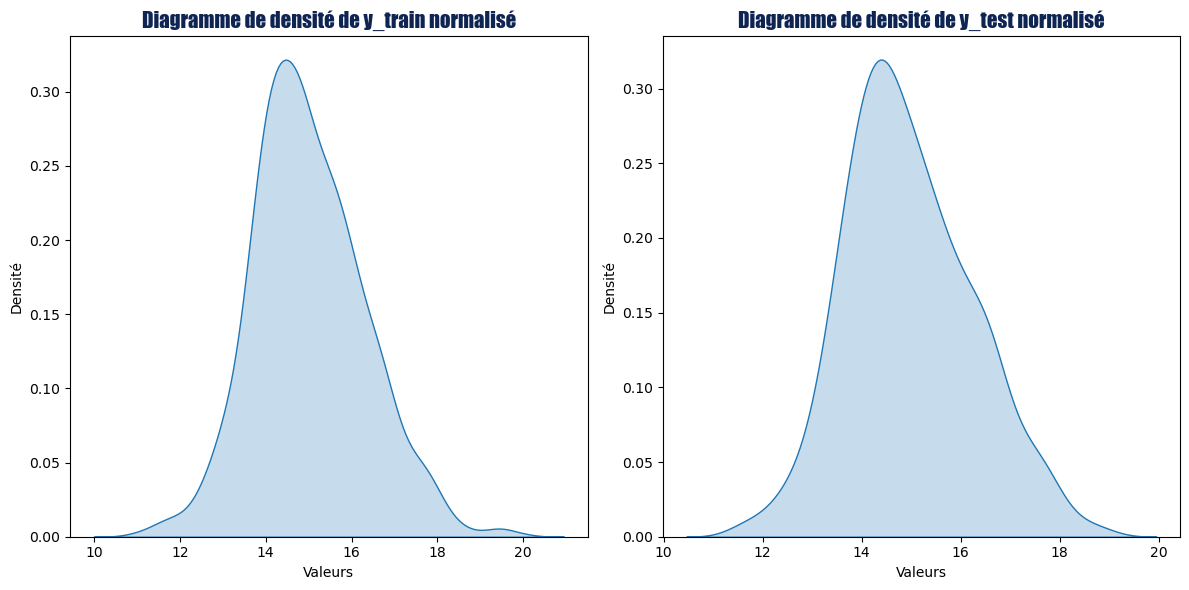

In [17]:
# Création de la figure et des axes
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Diagramme de densité pour y_train
sns.kdeplot(y_train_log, shade=True, ax=axes[0])

# Ajout de labels et de titre pour y_train
axes[0].set_xlabel('Valeurs')
axes[0].set_ylabel('Densité')
axes[0].set_title("Diagramme de densité de y_train normalisé", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")

# Diagramme de densité pour y_test
sns.kdeplot(y_test_log, shade=True, ax=axes[1])

# Ajout de labels et de titre pour y_test
axes[1].set_xlabel('Valeurs')
axes[1].set_ylabel('Densité')
axes[1].set_title("Diagramme de densité de y_test normalisé", fontsize=15, weight="bold", fontname="Impact", color="#0e2452")

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage du graphique
plt.show()

#### 5.1.7 - Création du score pour le r2 ajuste

In [18]:
def r2_ajuste(y_true, y_pred, X):
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)
    k = X.shape[1]
    r2_ajuste = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    return r2_ajuste

adjusted_r2_scorer = make_scorer(r2_ajuste, greater_is_better=True, X=X)


### 5.2 - Baseline = LinearRegression

In [19]:
# Définition du modèle
model_baseline = linear_model.LinearRegression()

# Entrainement du modèle
start_time = time.time()
model_baseline.fit(X_train_scaled, y_train_log)  
end_time = time.time()
total_time_lr = end_time - start_time
total_time_lr

0.16158485412597656

In [20]:
# Evaluation du train
y_train_pred = model_baseline.predict(X_train_scaled)
r2_train = r2_score(y_train_log, y_train_pred)
adjusted_r2_train = r2_ajuste(y_train_log, y_train_pred, X_train_scaled)

# Evaluation du test
y_test_pred = model_baseline.predict(X_test_scaled)
r2_test = r2_score(y_test_log, y_test_pred)
adjusted_r2_test = r2_ajuste(y_test_log, y_test_pred, X_test_scaled)


In [21]:
# Renvoie des résultats dans un df
results = pd.DataFrame({
'Model_Name': ["Linear regression"],
'Score_R2_Train': [r2_train],
'Score_R2_Test': [r2_test],
'Score_R2_Ajuste_Train': [adjusted_r2_train],
'Score_R2_Ajuste_Test': [adjusted_r2_test],
'Training_Time': [total_time_lr],
'Best_Parameters': ["None"]
    })

results

Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.643277       0.605532                0.62546   

   Score_R2_Ajuste_Test  Training_Time Best_Parameters  
0              0.556351       0.161585            None

In [22]:
# Création d'un DataFrame vide pour stocker les résultats
all_models_results = pd.DataFrame()

def evaluate_grid_search(grid_search, X_train, y_train, X_test, y_test, model_name):


    # Entrainement + temps
    start_time = datetime.now()
    grid_search.fit(X_train, y_train)
    end_time = datetime.now()
    training_time =  (end_time - start_time).total_seconds()
    
    # Best model 
    best_model = grid_search.best_estimator_
    
    # Best parameters
    best_params = grid_search.best_params_
    
    # Evaluation du train
    y_train_pred = best_model.predict(X_train)
    r2_train = r2_score(y_train, y_train_pred)
    adjusted_r2_train = r2_ajuste(y_train, y_train_pred, X_train)

    # Evaluation du test
    y_test_pred = best_model.predict(X_test)
    r2_test = r2_score(y_test, y_test_pred)
    adjusted_r2_test = r2_ajuste(y_test, y_test_pred, X_test)

    
    # Renvoie des résultats dans un df
    results = pd.DataFrame({
        'Model_Name': [model_name],
        'Score_R2_Train': [r2_train],
        'Score_R2_Test': [r2_test],
        'Score_R2_Ajuste_Train': [adjusted_r2_train],
        'Score_R2_Ajuste_Test': [adjusted_r2_test],
        'Training_Time': [training_time],
        'Best_Parameters': [best_params]
    })
    return results




### 5.3 - Autres modèles Linéaires

#### 5.3.1 - Ridge Régression

In [23]:
model = Ridge()

param_grid_ridge = {
    'alpha': [0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100],
}

grid_search_ridge = GridSearchCV(
    model,
    param_grid=param_grid_ridge,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1
)

In [24]:
models_results_ridge = evaluate_grid_search(grid_search_ridge, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'Régression Ridge').reset_index(drop=True)
all_results = pd.concat([results, models_results_ridge], ignore_index=True)
all_results

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.643277       0.605532               0.625460   
1   Régression Ridge        0.638043       0.616900               0.619964   

   Score_R2_Ajuste_Test  Training_Time Best_Parameters  
0              0.556351       0.161585            None  
1              0.569137       0.214196    {'alpha': 1}

#### 5.3.2 - Lasso

In [25]:
model = Lasso()

param_grid_lasso = {
    'alpha': [0.02, 0.024, 0.025, 0.026, 0.03],
}

grid_search_lasso = GridSearchCV(
    model,
    param_grid=param_grid_lasso,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1
)

In [26]:
models_results_lasso = evaluate_grid_search(grid_search_lasso, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'Lasso').reset_index(drop=True)
all_results = pd.concat([all_results, models_results_lasso], ignore_index=True)
all_results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.643277       0.605532               0.625460   
1   Régression Ridge        0.638043       0.616900               0.619964   
2              Lasso        0.541058       0.543199               0.518135   

   Score_R2_Ajuste_Test  Training_Time  Best_Parameters  
0              0.556351       0.161585             None  
1              0.569137       0.214196     {'alpha': 1}  
2              0.486247       0.097989  {'alpha': 0.02}

#### 5.3.3 - Elastic Net

In [27]:
model = ElasticNetCV()

param_grid_elasticnet = {
    'l1_ratio': [0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99],
    'alphas'     : [[0.001]]
}

grid_search_elasticnet = GridSearchCV(
    model,
    param_grid=param_grid_elasticnet,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1
)

In [28]:
pd.set_option('display.max_colwidth', None)
models_results_elasticnet = evaluate_grid_search(grid_search_elasticnet, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'ElasticNet').reset_index(drop=True)
all_models_results = pd.concat([all_models_results, models_results_elasticnet], ignore_index=True)
all_results= pd.concat([all_results,all_models_results], ignore_index=True)
all_results

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.643277       0.605532               0.625460   
1   Régression Ridge        0.638043       0.616900               0.619964   
2              Lasso        0.541058       0.543199               0.518135   
3         ElasticNet        0.641557       0.618150               0.623653   

   Score_R2_Ajuste_Test  Training_Time                        Best_Parameters  
0              0.556351       0.161585                                   None  
1              0.569137       0.214196                           {'alpha': 1}  
2              0.486247       0.097989                        {'alpha': 0.02}  
3              0.570543       1.182659  {'alphas': [0.001], 'l1_ratio': 0.99}

### 5.4 - SVM à noyau - (Kernel "rbf")

In [29]:
model = svm.SVR(kernel='rbf')

param_grid_svm_SVR = {
'C': [0.1,1,5,10,100,150,200],
'gamma': [1e-7, 1e-4],
'epsilon': [0.1,0.2,0.5,0.3]
}

grid_search_svm_SVR = GridSearchCV(
    model,
    param_grid=param_grid_svm_SVR,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1
)

In [30]:
pd.set_option('display.max_colwidth', None)
models_results_param_grid_svm_SVR= evaluate_grid_search(grid_search_svm_SVR, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'svm_SVR').reset_index(drop=True)
all_results = pd.concat([all_results, models_results_param_grid_svm_SVR], ignore_index=True)
all_results

Fitting 5 folds for each of 56 candidates, totalling 280 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.643277       0.605532               0.625460   
1   Régression Ridge        0.638043       0.616900               0.619964   
2              Lasso        0.541058       0.543199               0.518135   
3         ElasticNet        0.641557       0.618150               0.623653   
4            svm_SVR        0.664593       0.638210               0.647841   

   Score_R2_Ajuste_Test  Training_Time  \
0              0.556351       0.161585   
1              0.569137       0.214196   
2              0.486247       0.097989   
3              0.570543       1.182659   
4              0.593104       7.323344   

                               Best_Parameters  
0                                         None  
1                                 {'alpha': 1}  
2                              {'alpha': 0.02}  
3        {'alphas': [0.001], 'l1_ratio': 0.99}  
4  {'C': 200, 'epsilon': 0.1, 'gamma': 0.0001}

### 5.5 - Méthodes ensemblistes

#### 5.5.1 - Bagging = RandomForestRegressor

In [31]:
# Création d'une fonction pour faire un plot des HP

def plot_hyperparameter_tuning(grid_search, param_name, score_name):
    grid_search.fit(X_train_scaled, y_train_log)
    cv_results=grid_search.cv_results_
    # Extraire les données nécessaires de cv_results
    param_values = np.array(cv_results[f'param_{param_name}'].data)
    score_values = cv_results[f'mean_{score_name}']

    # Créer le plot
    plt.figure(figsize=(5, 5))
    plt.plot(param_values, score_values, marker='o', linestyle='-')

    # Ajouter des étiquettes et un titre
    plt.xlabel(f'{param_name}')
    plt.ylabel(f'Moyenne du score {score_name}')
    plt.title(f'Impact de {param_name} sur le score {score_name}')

    # Afficher le plot
    plt.grid(True)
    plt.show()

In [32]:
model = RandomForestRegressor(random_state=42)
param_grid_RF_regressor = {
    'n_estimators': [5,20,50,100,200,300,400,500], # nombre d'arbres dans la forêt
#     'max_depth': [2,3], # profondeur de chaque arbre
#     'min_samples_split': [5,10,50], # nombre minimum d'échantillons requis pour effectuer une division
#     'min_samples_leaf': [5,10,50] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


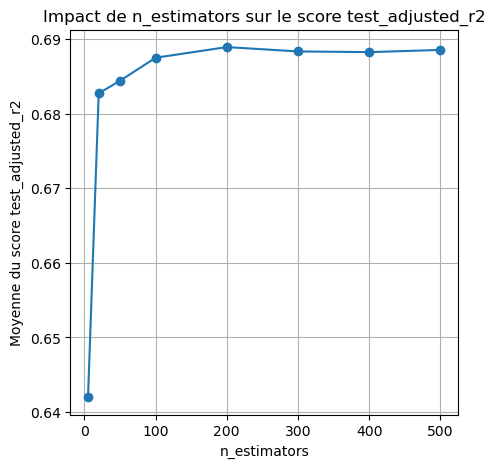

In [33]:
plot_hyperparameter_tuning(grid_search_RF_regressor, "n_estimators", 'test_adjusted_r2')

In [34]:
model = RandomForestRegressor(random_state=42)

param_grid_RF_regressor = {
#    'n_estimators': [5,20,50,100,200,300,400,500], # nombre d'arbres dans la forêt
     'max_depth': [1,2,3,4], # profondeur de chaque arbre
#     'min_samples_split': [5,10,50], # nombre minimum d'échantillons requis pour effectuer une division
#     'min_samples_leaf': [5,10,50] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


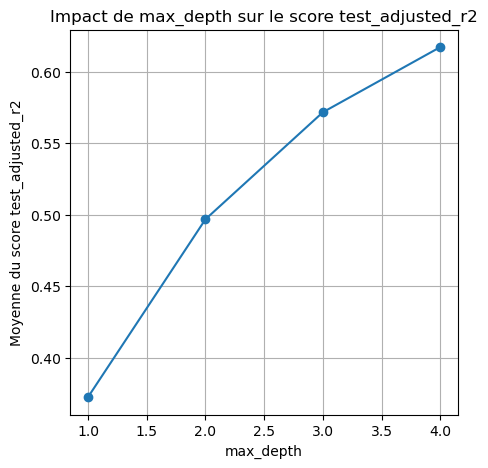

In [35]:
plot_hyperparameter_tuning(grid_search_RF_regressor, "max_depth", 'test_adjusted_r2')

In [36]:
model = RandomForestRegressor(random_state=42)

param_grid_RF_regressor = {
#    'n_estimators': [5,20,50,100,200,300,400,500], # nombre d'arbres dans la forêt
#      'max_depth': [1,2,3,4], # profondeur de chaque arbre
    'min_samples_split': [5,10,50], # nombre minimum d'échantillons requis pour effectuer une division
#     'min_samples_leaf': [5,10,50] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

In [37]:
plot_hyperparameter_tuning(grid_search_RF_regressor, "min_samples_split", 'test_adjusted_r2')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [38]:
model = RandomForestRegressor(random_state=42)

param_grid_RF_regressor = {
#    'n_estimators': [5,20,50,100,200,300,400,500], # nombre d'arbres dans la forêt
#      'max_depth': [1,2,3,4], # profondeur de chaque arbre
#    'min_samples_split': [5,10,50], # nombre minimum d'échantillons requis pour effectuer une division
     'min_samples_leaf': [5,10,50] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

In [39]:
plot_hyperparameter_tuning(grid_search_RF_regressor, "min_samples_leaf", 'test_adjusted_r2')

Fitting 5 folds for each of 3 candidates, totalling 15 fits


In [40]:
model = RandomForestRegressor(random_state=42)

param_grid_RF_regressor = {
    'n_estimators': [40,50,60], # nombre d'arbres dans la forêt
    'max_depth': [3,4], # profondeur de chaque arbre
    'min_samples_split': [50,10], # nombre minimum d'échantillons requis pour effectuer une division
     'min_samples_leaf': [5,10] # nombre minimum d'échantillons requis pour être une feuille
}

grid_search_RF_regressor = GridSearchCV(
    model,
    param_grid=param_grid_RF_regressor,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

In [41]:
pd.set_option('display.max_colwidth', None)
models_results_RF_regressor= evaluate_grid_search(grid_search_RF_regressor, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'RF_regressor').reset_index(drop=True)
all_results = pd.concat([all_results, models_results_RF_regressor], ignore_index=True)
all_results

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.643277       0.605532               0.625460   
1   Régression Ridge        0.638043       0.616900               0.619964   
2              Lasso        0.541058       0.543199               0.518135   
3         ElasticNet        0.641557       0.618150               0.623653   
4            svm_SVR        0.664593       0.638210               0.647841   
5       RF_regressor        0.700945       0.657669               0.686008   

   Score_R2_Ajuste_Test  Training_Time  \
0              0.556351       0.161585   
1              0.569137       0.214196   
2              0.486247       0.097989   
3              0.570543       1.182659   
4              0.593104       7.323344   
5              0.614989       3.521231   

                                                                        Best_Parameters  
0                                                                                  None  
1                                                                          {'alpha': 1}  
2                                                                       {'alpha': 0.02}  
3                                                 {'alphas': [0.001], 'l1_ratio': 0.99}  
4                                           {'C': 200, 'epsilon': 0.1, 'gamma': 0.0001}  
5  {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 40}

#### 5.5.2 - Boosting = XGBoost (eXtreme Gradient Boosting) 

In [42]:
!pip install --upgrade xgboost

In [43]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# 'max_depth': [2,3],
# 'min_child_weight' :[5, 15,50,100],
# 'colsample_bytree': [0.3,0.4,0.5],
# #'subsample': [1],
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


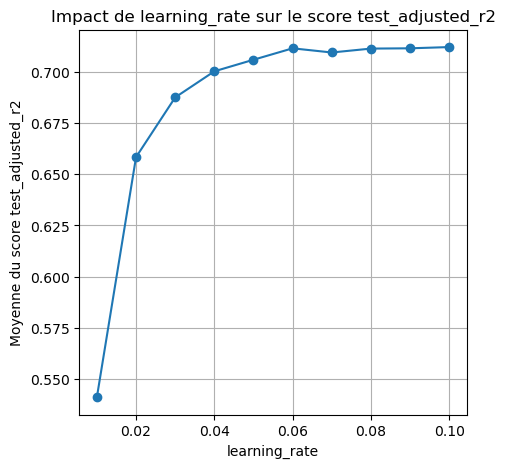

In [44]:
plot_hyperparameter_tuning(grid_search_XGB, "learning_rate", 'test_adjusted_r2')

In [45]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
#'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
 'max_depth': [1,2,3,4,5],
# 'min_child_weight' :[5, 15,50,100],
# 'colsample_bytree': [0.3,0.4,0.5],
# #'subsample': [1],
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

In [46]:
plot_hyperparameter_tuning(grid_search_XGB, "max_depth", 'test_adjusted_r2')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [47]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
#'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# 'max_depth': [1,2,3,4,5],
 'min_child_weight' :[5, 15,50,100],
# 'colsample_bytree': [0.3,0.4,0.5],
# #'subsample': [1],
}

grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

In [48]:
plot_hyperparameter_tuning(grid_search_XGB, "min_child_weight", 'test_adjusted_r2')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [49]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
#'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# 'max_depth': [1,2,3,4,5],
# 'min_child_weight' :[5, 15,50,100],
 'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
# #'subsample': [1],
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


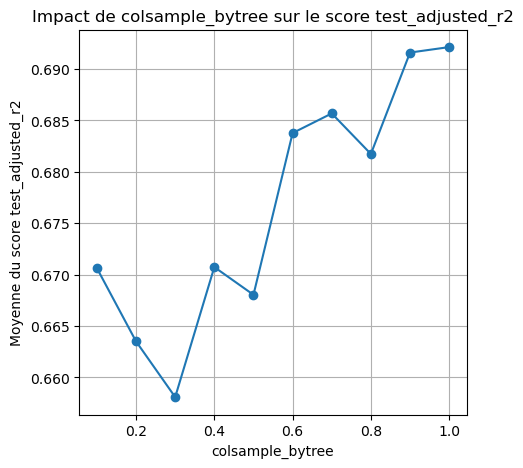

In [50]:
plot_hyperparameter_tuning(grid_search_XGB, "colsample_bytree", 'test_adjusted_r2')

In [51]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
#'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# 'max_depth': [1,2,3,4,5],
# 'min_child_weight' :[5, 15,50,100],
# 'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
}
 

grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

In [52]:
plot_hyperparameter_tuning(grid_search_XGB, "subsample", 'test_adjusted_r2')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [53]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
#'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
# 'max_depth': [1,2,3,4,5],
# 'min_child_weight' :[5, 15,50,100],
# 'colsample_bytree': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
#'subsample': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
 'lambda' :[1,5,10,20]   
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


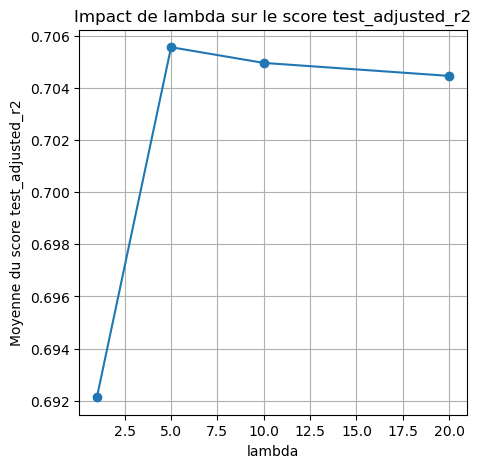

In [54]:
plot_hyperparameter_tuning(grid_search_XGB, "lambda", 'test_adjusted_r2')

In [55]:
model = XGBRegressor(random_state=42)

param_grid_XGB = {
'learning_rate': [0.07,0.08,0.1],
'max_depth': [1,2,3],
'min_child_weight' :[15,20,25],
'colsample_bytree': [0.7,0.80],
'subsample': [0.8,0.9,1],
'lambda':[5,20],
}
 
grid_search_XGB = GridSearchCV(
    model,
    param_grid=param_grid_XGB,
    scoring={'r2': 'r2', 'adjusted_r2': adjusted_r2_scorer},
    refit='adjusted_r2', 
    cv=5,  
    verbose=1,
    n_jobs=-1
)

In [56]:
pd.set_option('display.max_colwidth', None)
models_results_XGB= evaluate_grid_search(grid_search_XGB, X_train_scaled, y_train_log, X_test_scaled, y_test_log, 'XGB').reset_index(drop=True)
all_results = pd.concat([all_results, models_results_XGB], ignore_index=True)
all_results

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


Model_Name  Score_R2_Train  Score_R2_Test  Score_R2_Ajuste_Train  \
0  Linear regression        0.643277       0.605532               0.625460   
1   Régression Ridge        0.638043       0.616900               0.619964   
2              Lasso        0.541058       0.543199               0.518135   
3         ElasticNet        0.641557       0.618150               0.623653   
4            svm_SVR        0.664593       0.638210               0.647841   
5       RF_regressor        0.700945       0.657669               0.686008   
6                XGB        0.817181       0.768195               0.808049   

   Score_R2_Ajuste_Test  Training_Time  \
0              0.556351       0.161585   
1              0.569137       0.214196   
2              0.486247       0.097989   
3              0.570543       1.182659   
4              0.593104       7.323344   
5              0.614989       3.521231   
6              0.739295       9.905190   

                                                                                                          Best_Parameters  
0                                                                                                                    None  
1                                                                                                            {'alpha': 1}  
2                                                                                                         {'alpha': 0.02}  
3                                                                                   {'alphas': [0.001], 'l1_ratio': 0.99}  
4                                                                             {'C': 200, 'epsilon': 0.1, 'gamma': 0.0001}  
5                                    {'max_depth': 4, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 40}  
6  {'colsample_bytree': 0.7, 'lambda': 5, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 15, 'subsample': 0.9}

## 6 - Analyse des résultats

### 6.1 - Consolidation des résultats

In [57]:
# Données pour le premier graphique
bar_positions = np.arange(len(all_results['Model_Name']))
r2_train = all_results['Score_R2_Ajuste_Train']
r2_test = all_results['Score_R2_Ajuste_Test']
Training_Time = all_results['Training_Time']

# Créer une figure avec deux sous-graphiques (1 ligne, 2 colonnes)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Premier sous-graphique : Score R² ajusté en ligne
axs[0].plot(bar_positions, r2_train, marker='o', linestyle='-', color='#ff69b4', label='R2_Ajuste_Train')
axs[0].plot(bar_positions, r2_test, marker='o', linestyle='-', color='#1a662b', label='R2_Ajuste_Test')
axs[0].set_xticks(bar_positions)
axs[0].set_xticklabels(all_results['Model_Name'], rotation=60)
axs[0].set_xlabel("Model")
axs[0].set_ylabel("Score R² ajusté")
axs[0].set_title("Score R² ajusté des modèles")
axs[0].legend()
axs[0].grid(True)

# Deuxième sous-graphique : Temps d'entraînement en ligne
axs[1].plot(bar_positions, Training_Time, marker='o', linestyle='-', color='#7d69ff', label='Training_Time')
axs[1].set_xticks(bar_positions)
axs[1].set_xticklabels(all_results['Model_Name'], rotation=60)
axs[1].set_xlabel("Model")
axs[1].set_ylabel("Training_Time")
axs[1].set_title("Temps d'entraînement des modèles")
axs[1].legend()
axs[1].grid(True)

# Ajustement de l'espacement entre les sous-graphiques
plt.tight_layout()

# Affichage de la figure
plt.show()



C'est le XGB qui performe le mieux sur le test avec overfitting de l'ordre de 6/7 points

### 6.2 - Analyse des prédictions du test

In [58]:
# Le meilleur modèle
best_model = grid_search_XGB.best_estimator_
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=5, learning_rate=0.1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=15, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

In [59]:
# Faire des prédictions avec le meilleur modèle
y_pred_test = best_model.predict(X_test_scaled)


In [60]:
# Retour à l'exponentiel
y_pred_test_exp = np.expm1(y_pred_test)
y_test_exp = np.expm1(y_test_log)

#### 6.2.1 - Consolidation du X_test, y_test et y_pred_test

In [61]:
X_test.columns

Index(['BuildingType', 'PrimaryPropertyType', 'LargestPropertyUseTypeGFA',
       'Neighborhood', 'NombreUsages', 'Age_Cluster', 'NumberofBuildings',
       'ratio_elec', 'GFAParking_ratio', 'Office', 'Parking',
       'Non-Refrigerated Warehouse', 'Data Center', 'College/University',
       'Laboratory', 'Distribution Center', 'Fitness Center/Health Club/Gym'],
      dtype='object')

In [62]:
df_X_test = pd.DataFrame(X_test, columns=X_test.columns)
df_X_test.shape

(434, 17)

In [63]:
df_X_test.head()

BuildingType          PrimaryPropertyType  LargestPropertyUseTypeGFA  \
413   NonResidential                 Large Office                   914832.0   
316   NonResidential          Distribution Center                   124423.0   
1034  NonResidential               Medical Office                    20575.0   
65    NonResidential  Small- and Mid-Sized Office                    45900.0   
1024  NonResidential          Distribution Center                    18470.0   

               Neighborhood  NombreUsages Age_Cluster  NumberofBuildings  \
413                DOWNTOWN             5           1                1.0   
316        GREATER DUWAMISH             2           2                1.0   
1034                  NORTH             1           1                1.0   
65    MAGNOLIA & QUEEN ANNE             5           1                1.0   
1024       GREATER DUWAMISH             2           2                1.0   

      ratio_elec  GFAParking_ratio    Office   Parking  \
413     0.975664          0.000000  0.574313  0.218962   
316     0.209699          0.000000  0.000000  0.000000   
1034    1.000000          0.248582  0.000000  0.000000   
65      1.000000          0.035507  0.692935  0.000000   
1024    0.641765          0.000000  0.241603  0.000000   

      Non-Refrigerated Warehouse  Data Center  College/University  Laboratory  \
413                          0.0     0.000000                 0.0         0.0   
316                          0.0     0.000000                 0.0         0.0   
1034                         0.0     0.000000                 0.0         0.0   
65                           0.0     0.078216                 0.0         0.0   
1024                         0.0     0.000000                 0.0         0.0   

      Distribution Center  Fitness Center/Health Club/Gym  
413              0.000000                             0.0  
316              0.999606                             0.0  
1034             0.000000                             0.0  
65               0.068705                             0.0  
1024             0.758397                             0.0

In [64]:
# Création d'un Dataframe avec les y_test and y_pred_test
df_results = pd.DataFrame({'y_test': y_test_exp, 'y_pred_test': y_pred_test_exp})
df_results.shape

(434, 2)

In [65]:
# Concaténation des 2
df_combined = pd.concat([df_X_test, df_results], axis=1)
df_combined.shape

(434, 19)

In [66]:
df_combined.head()

BuildingType          PrimaryPropertyType  LargestPropertyUseTypeGFA  \
413   NonResidential                 Large Office                   914832.0   
316   NonResidential          Distribution Center                   124423.0   
1034  NonResidential               Medical Office                    20575.0   
65    NonResidential  Small- and Mid-Sized Office                    45900.0   
1024  NonResidential          Distribution Center                    18470.0   

               Neighborhood  NombreUsages Age_Cluster  NumberofBuildings  \
413                DOWNTOWN             5           1                1.0   
316        GREATER DUWAMISH             2           2                1.0   
1034                  NORTH             1           1                1.0   
65    MAGNOLIA & QUEEN ANNE             5           1                1.0   
1024       GREATER DUWAMISH             2           2                1.0   

      ratio_elec  GFAParking_ratio    Office   Parking  \
413     0.975664          0.000000  0.574313  0.218962   
316     0.209699          0.000000  0.000000  0.000000   
1034    1.000000          0.248582  0.000000  0.000000   
65      1.000000          0.035507  0.692935  0.000000   
1024    0.641765          0.000000  0.241603  0.000000   

      Non-Refrigerated Warehouse  Data Center  College/University  Laboratory  \
413                          0.0     0.000000                 0.0         0.0   
316                          0.0     0.000000                 0.0         0.0   
1034                         0.0     0.000000                 0.0         0.0   
65                           0.0     0.078216                 0.0         0.0   
1024                         0.0     0.000000                 0.0         0.0   

      Distribution Center  Fitness Center/Health Club/Gym        y_test  \
413              0.000000                             0.0  5.678592e+07   
316              0.999606                             0.0  6.345882e+06   
1034             0.000000                             0.0  2.654316e+06   
65               0.068705                             0.0  4.192108e+06   
1024             0.758397                             0.0  7.359078e+05   

       y_pred_test  
413   6.808778e+07  
316   3.630466e+06  
1034  8.059730e+05  
65    5.520421e+06  
1024  1.043490e+06

Vérification que mon Dataframe récap est ok avec l'exemple de l'individu d'index 413

In [67]:
pd.set_option('display.max_rows', None)
final_df[(final_df['PrimaryPropertyType']=='Large Office')&(final_df['Neighborhood']=='DOWNTOWN')&(final_df['LargestPropertyUseTypeGFA']==914832.0)][['BuildingType',
                                                                                                                                                      'PrimaryPropertyType',
                                                                                                                                                      'LargestPropertyUseTypeGFA',
                                                                                                                                                      'Neighborhood',
                                                                                                                                                      'NombreUsages',
                                                                                                                                                      'Age_Cluster',
                                                                                                                                                      'NumberofBuildings',
                                                                                                                                                      'ratio_elec']]

BuildingType PrimaryPropertyType  LargestPropertyUseTypeGFA  \
413  NonResidential        Large Office                   914832.0   

    Neighborhood  NombreUsages Age_Cluster  NumberofBuildings  ratio_elec  
413     DOWNTOWN             5           1                1.0    0.975664

In [68]:
df_combined[(df_combined['PrimaryPropertyType']=='Large Office')&(df_combined['Neighborhood']=='DOWNTOWN')&(df_combined['LargestPropertyUseTypeGFA']==914832.0)][['BuildingType',
                                                                                                                                                      'PrimaryPropertyType',
                                                                                                                                                      'LargestPropertyUseTypeGFA',
                                                                                                                                                      'Neighborhood',
                                                                                                                                                      'NombreUsages',
                                                                                                                                                      'Age_Cluster',
                                                                                                                                                      'NumberofBuildings',
                                                                                                                                                      'ratio_elec']]

BuildingType PrimaryPropertyType  LargestPropertyUseTypeGFA  \
413  NonResidential        Large Office                   914832.0   

    Neighborhood  NombreUsages Age_Cluster  NumberofBuildings  ratio_elec  
413     DOWNTOWN             5           1                1.0    0.975664

C'est ok

In [69]:
df_combined['écart_true_pred'] = abs(df_combined['y_test'] - df_combined['y_pred_test'])
df_combined = df_combined.sort_values(by='écart_true_pred', ascending=False)
df_combined.head()

BuildingType PrimaryPropertyType  LargestPropertyUseTypeGFA  \
274           Campus               Other                   535947.0   
243   NonResidential  Mixed Use Property                   104922.0   
1161          Campus          University                   533826.0   
123   NonResidential              Autres                   601615.0   
170   NonResidential        Large Office                   581558.0   

               Neighborhood  NombreUsages Age_Cluster  NumberofBuildings  \
274              LAKE UNION             2           1                1.0   
243              LAKE UNION             6           1                1.0   
1161  MAGNOLIA & QUEEN ANNE             1           2               14.0   
123                 CENTRAL             2           1                6.0   
170                DOWNTOWN             4           2                1.0   

      ratio_elec  GFAParking_ratio    Office   Parking  \
274     0.491935           0.00000  0.000000  0.194017   
243     0.997915           0.49067  0.176403  0.490670   
1161    0.249632           0.00000  0.000000  0.000000   
123     0.409662           0.00000  0.000000  0.081348   
170     0.987299           0.27765  0.941514  0.306953   

      Non-Refrigerated Warehouse  Data Center  College/University  Laboratory  \
274                          0.0     0.000000            0.000000         0.0   
243                          0.0     0.254333            0.000000         0.0   
1161                         0.0     0.000000            0.994089         0.0   
123                          0.0     0.000000            0.000000         0.0   
170                          0.0     0.000000            0.000000         0.0   

      Distribution Center  Fitness Center/Health Club/Gym       y_test  \
274                   0.0                             0.0  137106112.0   
243                   0.0                             0.0   75073888.0   
1161                  0.0                             0.0   96775464.0   
123                   0.0                             0.0  147299056.0   
170                   0.0                             0.0   71568952.0   

      y_pred_test  écart_true_pred  
274    64003064.0       73103048.0  
243    22542908.0       52530980.0  
1161   45503284.0       51272180.0  
123   100187696.0       47111360.0  
170    29486688.0       42082264.0

In [70]:
fig = plt.figure(figsize=(8,5))
plt.scatter(df_combined['y_test'],df_combined['y_pred_test'], color='r', alpha=.6)
plt.xlabel("Valeurs réélles")
plt.ylabel("Valeurs prédites")
plt.title("Test : Valeurs prédites VS valeurs réélles",fontsize=20, weight="bold", fontname="Impact", color="#0e2452")
plt.show()

#### 6.2.2 - Best and Worse Predictions du test

In [71]:
worst_5=df_combined.head()
worst_5[['PrimaryPropertyType', 'y_test','y_pred_test','écart_true_pred']]

PrimaryPropertyType       y_test  y_pred_test  écart_true_pred
274                Other  137106112.0   64003064.0       73103048.0
243   Mixed Use Property   75073888.0   22542908.0       52530980.0
1161          University   96775464.0   45503284.0       51272180.0
123               Autres  147299056.0  100187696.0       47111360.0
170         Large Office   71568952.0   29486688.0       42082264.0

In [72]:
best_5=df_combined.tail()
best_5[['PrimaryPropertyType', 'y_test','y_pred_test','écart_true_pred']]

PrimaryPropertyType        y_test   y_pred_test  écart_true_pred
1221                  K-12 School  1.331981e+06  1.347661e+06       15680.1250
1285  Small- and Mid-Sized Office  1.394294e+06  1.380212e+06       14081.0000
435   Small- and Mid-Sized Office  8.301000e+05  8.418884e+05       11788.4375
945   Small- and Mid-Sized Office  3.098384e+06  3.088420e+06        9963.5000
818                     Warehouse  8.789333e+05  8.694168e+05        9516.5000

#### 6.2.3 - Analyse des erreurs du test par Primary Property type

In [73]:

nombre_individus_par_type = df_combined.groupby('PrimaryPropertyType').size()

Compar_PrimaryPropertyType = df_combined.groupby('PrimaryPropertyType')[['y_test', 'y_pred_test', 'écart_true_pred']].mean()
Compar_PrimaryPropertyType['Nombre d\'individus'] = nombre_individus_par_type
Compar_PrimaryPropertyType = Compar_PrimaryPropertyType.reset_index()
Compar_PrimaryPropertyType = Compar_PrimaryPropertyType.sort_values(by='écart_true_pred', ascending=False)

Compar_PrimaryPropertyType


PrimaryPropertyType        y_test   y_pred_test  écart_true_pred  \
12                   University  3.382283e+07  2.149200e+07     1.403895e+07   
0                        Autres  2.194797e+07  1.866457e+07     6.963713e+06   
4                  Large Office  1.968437e+07  1.887873e+07     6.250282e+06   
6            Mixed Use Property  1.007132e+07  5.430753e+06     4.913195e+06   
7                         Other  9.034717e+06  5.731344e+06     4.607973e+06   
2                         Hotel  8.855770e+06  7.460654e+06     3.589899e+06   
11  Supermarket / Grocery Store  9.795104e+06  7.627984e+06     2.875678e+06   
8                  Retail Store  4.654003e+06  3.434339e+06     2.596073e+06   
5                Medical Office  8.668956e+06  6.600651e+06     2.068305e+06   
13                    Warehouse  3.024595e+06  2.483316e+06     1.783308e+06   
3                   K-12 School  3.188171e+06  4.178314e+06     1.395996e+06   
1           Distribution Center  2.627121e+06  1.801948e+06     1.387088e+06   
10  Small- and Mid-Sized Office  2.688589e+06  2.505958e+06     9.298070e+05   
9         Self-Storage Facility  9.096403e+05  9.780216e+05     3.550019e+05   
14             Worship Facility  9.342273e+05  1.103581e+06     2.784555e+05   

    Nombre d'individus  
12                   4  
0                   13  
4                   48  
6                   26  
7                   71  
2                   18  
11                  15  
8                   32  
5                   13  
13                  52  
3                   13  
1                   15  
10                  84  
9                    6  
14                  24

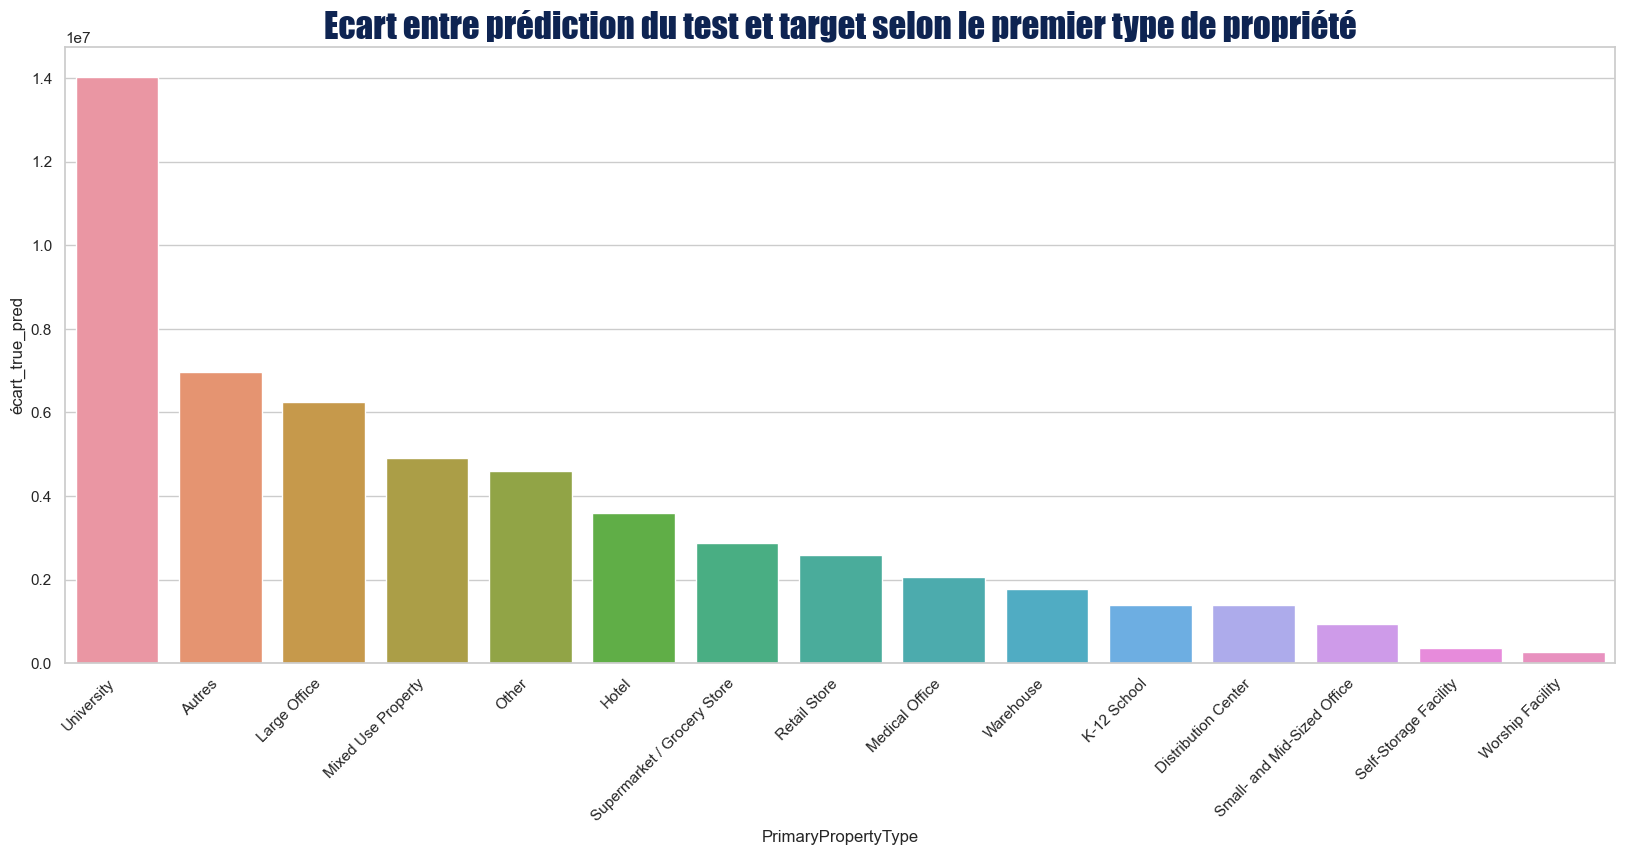

In [74]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 8))
ax = sns.barplot(x='PrimaryPropertyType', y='écart_true_pred', data=Compar_PrimaryPropertyType)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.title("Ecart entre prédiction du test et target selon le premier type de propriété", fontsize=25, weight="bold", fontname="Impact", color="#0e2452")

plt.show()



La consommation d'énergie des catégories "University" est la plus difficile à prédire par mon modèle.

### 6.3 - Analyse de la cross_validation

In [75]:
# cross-validation results
cv_results = grid_search_XGB.cv_results_


In [76]:
# Convertir cv_results_ en DataFrame
df_cv_results = pd.DataFrame(cv_results)
df_cv_results=df_cv_results.sort_values(by="rank_test_adjusted_r2", ascending=True)
df_cv_results

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
73        0.065540      0.004612         0.010983        0.006235   
235       0.076636      0.006533         0.003128        0.006256   
74        0.062100      0.005902         0.009487        0.005944   
236       0.065455      0.003273         0.006263        0.008214   
208       0.079859      0.006035         0.003348        0.004100   
234       0.080504      0.010555         0.001631        0.003261   
72        0.073922      0.005843         0.005470        0.005906   
209       0.076826      0.011430         0.004673        0.003137   
47        0.078616      0.018223         0.004731        0.005769   
46        0.071481      0.004937         0.003214        0.006207   
316       0.077984      0.007604         0.007226        0.005602   
181       0.077091      0.002979         0.006518        0.003265   
207       0.084801      0.007686         0.009307        0.012137   
19        0.068345      0.012008         0.002898        0.005796   
317       0.077507      0.012963         0.001103        0.002206   
182       0.071128      0.004857         0.003304        0.004050   
155       0.077522      0.007718         0.006550        0.007803   
226       0.066674      0.004476         0.004214        0.003828   
20        0.061503      0.008175         0.003350        0.004110   
45        0.075467      0.003495         0.006433        0.006019   
154       0.091001      0.005798         0.004754        0.003534   
64        0.082739      0.026857         0.004067        0.006061   
225       0.063454      0.004611         0.007164        0.007107   
180       0.075025      0.005853         0.000000        0.000000   
65        0.064658      0.009523         0.000942        0.001884   
227       0.061306      0.010881         0.006176        0.003145   
153       0.091648      0.005958         0.005538        0.003462   
315       0.069470      0.006396         0.005228        0.006604   
63        0.077302      0.013609         0.004754        0.003641   
290       0.070756      0.008936         0.007033        0.007059   
18        0.069406      0.007318         0.003125        0.006250   
289       0.080225      0.009375         0.005280        0.005768   
127       0.071351      0.007131         0.000777        0.001554   
128       0.064412      0.012642         0.007876        0.006510   
199       0.059539      0.004215         0.003287        0.004026   
288       0.076760      0.006692         0.005750        0.001110   
238       0.075652      0.006420         0.003128        0.006256   
263       0.072046      0.012702         0.005728        0.007064   
239       0.072462      0.007725         0.000000        0.000000   
37        0.073135      0.010417         0.005347        0.005293   
77        0.091236      0.013930         0.004099        0.004424   
126       0.078705      0.008912         0.002105        0.004210   
262       0.076388      0.005506         0.003124        0.006247   
198       0.059564      0.006501         0.003285        0.004023   
76        0.078433      0.019178         0.007054        0.007151   
200       0.056790      0.005145         0.003003        0.003691   
101       0.071927      0.011229         0.005015        0.006246   
100       0.087071      0.012001         0.002150        0.002884   
38        0.065024      0.006689         0.005155        0.002765   
36        0.089795      0.014886         0.004493        0.003907   
212       0.074498      0.016419         0.004861        0.004181   
211       0.080502      0.014160         0.004986        0.004080   
75        0.083054      0.014262         0.002495        0.003291   
319       0.086925      0.013259         0.002143        0.003116   
145       0.056707      0.007881         0.009356        0.007639   
237       0.075185      0.006383         0.003126        0.006252   
307       0.062827      0.003876         0.005228        0.006605   
50 

In [77]:
# Les résultats de la combinaison la mieux classée
df_cv_results.iloc[0]

mean_fit_time                                                                                                                             0.06554
std_fit_time                                                                                                                             0.004612
mean_score_time                                                                                                                          0.010983
std_score_time                                                                                                                           0.006235
param_colsample_bytree                                                                                                                        0.7
param_lambda                                                                                                                                    5
param_learning_rate                                                                                                         

In [78]:
df_test_results = df_cv_results[['split0_test_adjusted_r2',
                'split1_test_adjusted_r2',
                'split2_test_adjusted_r2',
                'split3_test_adjusted_r2',
                'split4_test_adjusted_r2']][df_cv_results['rank_test_adjusted_r2']==1].values

df_test_results

array([[0.73784552, 0.75956143, 0.72929231, 0.71863288, 0.65278769]])

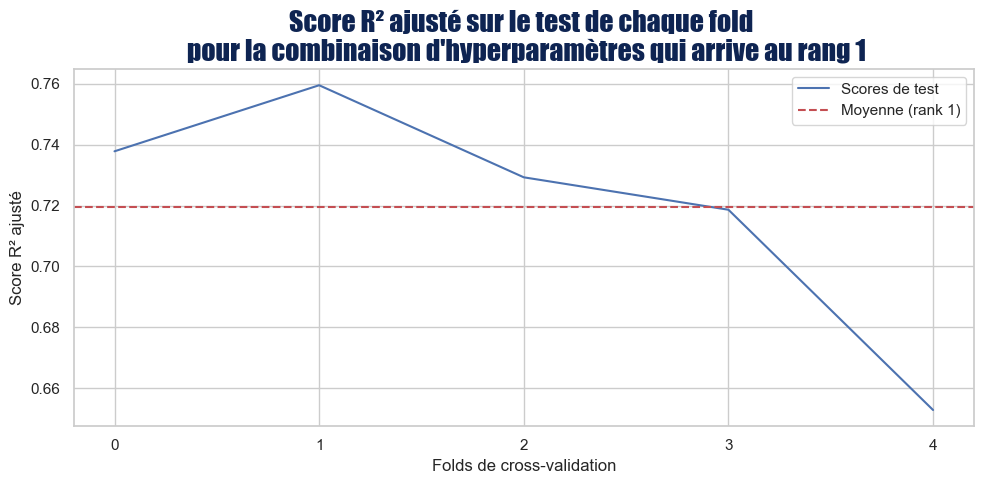

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))

# Tracer les scores de test
ax.plot(range(0, 5), df_test_results.reshape(-1), label='Scores de test')

# Tracer la moyenne pour les combinaisons avec rank_test_adjusted_r2 == 1
mean_scores_rank_1 = df_cv_results.loc[df_cv_results['rank_test_adjusted_r2'] == 1, 'mean_test_adjusted_r2']
ax.axhline(y=mean_scores_rank_1.values[0], color='r', linestyle='--', label='Moyenne (rank 1)')

# Définir les propriétés de l'axe
ax.set_xticks(range(0, 5))
ax.set_xlabel("Folds de cross-validation")
ax.set_ylabel('Score R² ajusté')
ax.set_title("Score R² ajusté sur le test de chaque fold \n pour la combinaison d'hyperparamètres qui arrive au rang 1", fontsize=20,weight="bold", fontname="Impact", color="#0e2452")

# Ajouter une légende
ax.legend()

fig.tight_layout()

plt.show()

Les 5 folds de la combinaison n°1 ont une prédiction entre 0.65 et 0.76

## 7 - Interprétabilité du modèle

Il faut maintenant que l'on comprenne ce modèle, qu'il soit interpétable d'un point de vue business. Quel est l'impact de chacune de mes variables sur le modèle ? Comment contribuent-elles à la prédiction finale ?

### 7.1 - Interprétation des résultats  pour l'individu le plus mal prédit du test

On sait que c'est l'individu 274 qui est le plus mal prédit du test. Je le déplace au début du dataframe pour pouvoir le trouver facilement dans les shap values

In [80]:
 X_test_encoded.loc[274]

LargestPropertyUseTypeGFA                          535947.0
NombreUsages                                              2
NumberofBuildings                                       1.0
ratio_elec                                         0.491935
GFAParking_ratio                                        0.0
Office                                                  0.0
Parking                                            0.194017
Non-Refrigerated Warehouse                              0.0
Data Center                                             0.0
College/University                                      0.0
Laboratory                                              0.0
Distribution Center                                     0.0
Fitness Center/Health Club/Gym                          0.0
BuildingType_Autres                                   False
BuildingType_Campus                                    True
BuildingType_NonResidential                           False
BuildingType_Nonresidential COS         

In [81]:
# Extraire la ligne d'index 274
row_to_move = X_test_encoded.loc[274]

# Supprimer la ligne d'index 274 du DataFrame
X_test_encoded = X_test_encoded.drop(274)

# Insérer la ligne au début du DataFrame
X_test_encoded = pd.concat([row_to_move.to_frame().transpose(), X_test_encoded], ignore_index=True)


In [82]:
X_test_encoded.head()

LargestPropertyUseTypeGFA NombreUsages NumberofBuildings ratio_elec  \
0                  535947.0            2               1.0   0.491935   
1                  914832.0            5               1.0   0.975664   
2                  124423.0            2               1.0   0.209699   
3                   20575.0            1               1.0        1.0   
4                   45900.0            5               1.0        1.0   

  GFAParking_ratio    Office   Parking Non-Refrigerated Warehouse Data Center  \
0              0.0       0.0  0.194017                        0.0         0.0   
1              0.0  0.574313  0.218962                        0.0         0.0   
2              0.0       0.0       0.0                        0.0         0.0   
3         0.248582       0.0       0.0                        0.0         0.0   
4         0.035507  0.692935       0.0                        0.0    0.078216   

  College/University  ... Neighborhood_LAKE UNION  \
0                0.0  ...                    True   
1                0.0  ...                   False   
2                0.0  ...                   False   
3                0.0  ...                   False   
4                0.0  ...                   False   

  Neighborhood_MAGNOLIA & QUEEN ANNE Neighborhood_NORTH  \
0                              False              False   
1                              False              False   
2                              False              False   
3                              False               True   
4                               True              False   

  Neighborhood_NORTHEAST Neighborhood_NORTHWEST Neighborhood_SOUTHEAST  \
0                  False                  False                  False   
1                  False                  False                  False   
2                  False                  False                  False   
3                  False                  False                  False   
4                  False                  False                  False   

  Neighborhood_SOUTHWEST Age_Cluster_0 Age_Cluster_1 Age_Cluster_2  
0                  False         False          True         False  
1                  False         False          True         False  
2                  False         False         False          True  
3                  False         False          True         False  
4                  False         False          True         False  

[5 rows x 48 columns]

**Création de l'objet explainer**

In [83]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, lambda=5, learning_rate=0.1,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=15, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

In [84]:
best_model_explainer=shap.TreeExplainer(best_model, X_train_scaled)

In [85]:
sample_idx = 0

shap_vals = best_model_explainer.shap_values(X_test_scaled[sample_idx])

print("Expected/Base Value : ", best_model_explainer.expected_value)
print()
print("Shap Values for Sample %d : "%sample_idx, shap_vals)
print("\n")
print("Prediction From Model                            : ", best_model.predict(X_test_scaled[sample_idx].reshape(1,-1))[0])
print("Prediction From Adding SHAP Values to Base Value : ", best_model_explainer.expected_value + shap_vals.sum())

Expected/Base Value :  14.95173985580259

Shap Values for Sample 0 :  [ 2.63832004e+00  9.91126369e-02  0.00000000e+00 -1.85845704e-01
  6.81962256e-03  1.13939989e-01  5.58993578e-02  6.78998425e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.60104669e-02
  0.00000000e+00  0.00000000e+00 -4.35381364e-04 -8.74428362e-03
 -3.04623901e-03 -5.20490179e-03  7.12733977e-03 -5.29004261e-04
  4.56173843e-03  2.26093441e-01 -3.81980546e-03 -1.45046244e-02
 -1.82752603e-02  0.00000000e+00  2.38150578e-02  3.99753848e-03
 -2.21454738e-02  0.00000000e+00  5.50277866e-03  7.32078549e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  2.15815410e-03
 -1.22050818e-03  1.63069259e-03  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  3.99681833e-03
  0.00000000e+00  8.06178966e-03  4.75461845e-02 -1.47055144e-03]


Prediction From Model                            :  18.036308
Prediction From Adding SHAP Values to Base Value :  18.036312393957488


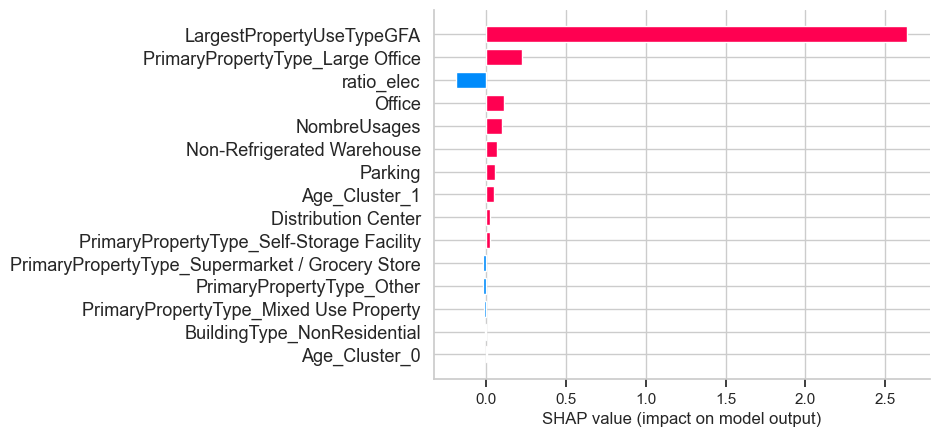

In [86]:
shap.bar_plot(best_model_explainer.shap_values(X_test_scaled[0]),
              feature_names=X_test_encoded.columns,
              max_display=15)

Pour l'individu le plus mal prédit, c'est la surface du 1er type d'utilisation du bâtiment qui contribue largement le plus positivement à la prédiction.  
Le % d'électricité dans le total (elec+gaz+vapeur d'eau) qui contribue principalement négativement à la prédiction

In [87]:
shap_values = best_model_explainer(X_test_scaled[:1])
shap_values.feature_names = X_test_encoded.columns.tolist()

shap.waterfall_plot(shap_values[0], max_display=10)

L'explication ci-dessus montre les caractéristiques contribuant chacune à faire passer la sortie du modèle de la valeur de base (la sortie moyenne du modèle sur l'ensemble de données de formation que nous avons passé) à la sortie du modèle. Les caractéristiques qui augmentent la prédiction sont représentées en rouge, celles qui la diminuent sont représentées en bleu

On part d'une Expected/Base Value de 14.95 (en bas) et on voit en remontant comment les variables contribuent à la prédiction final de 18

### 7.2 - Interprétation globale

In [88]:
shap.summary_plot(best_model_explainer.shap_values(X_test_scaled),
                  features = X_test_scaled,
                  feature_names=X_test_encoded.columns,
                   plot_size=(10, 6))



Plus la surface du 1er type d'utilisation du bâtiment augmente, plus elle contribue positivement à la prédiction globale.  
Plus le ratio d'électricité augmente, plus il participe négativement à la prédiction

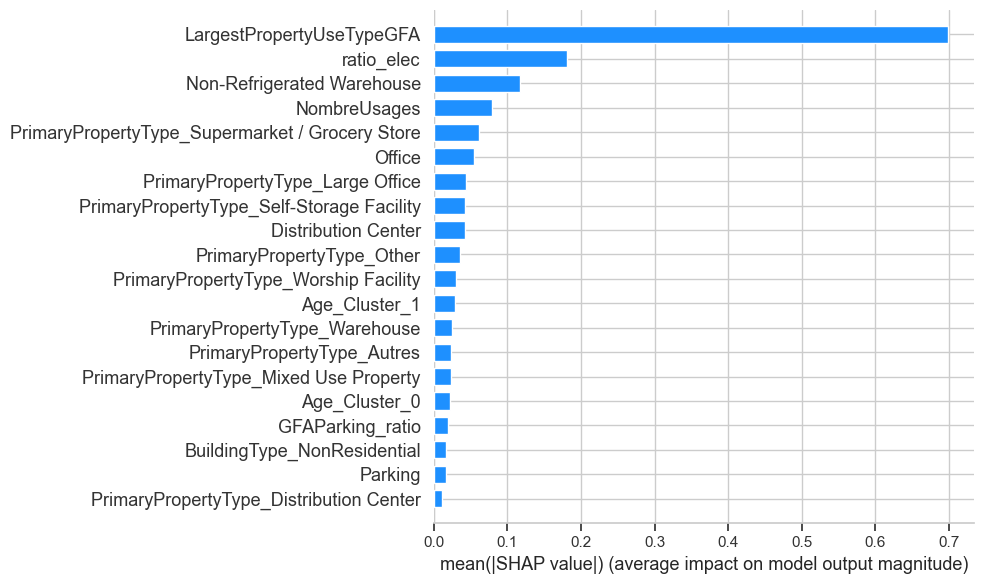

In [89]:
shap.summary_plot(best_model_explainer.shap_values(X_test_scaled),
                  feature_names=X_test_encoded.columns,
                  plot_type="bar",
                  color="dodgerblue",
                 plot_size=(10, 6))